In [1]:
#import deepdiagonstics
import models
import data
from utils.config import Config
from utils.register import register_simulator

from plots import CDFRanks, CoverageFraction, Ranks, TARP, LocalTwoSampleTest

import yaml



/Users/maggiev-local/Library/Caches/pypoetry/virtualenvs/deepdiagnostics-081AeCAa-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings('ignore')

## Introduction to DeepDiagnostics 

DeepDiagnostics is a command-line utility for running simulation-based inference (sbi) methods. 
It works primarily by interacting with a yaml file to overwrite defaults and specify what diagnostics to run and how.

### Configuration 

The configuration files controls most of DeepDiagnostics. 
It is broken into 7 parts. 
* Common

This controls things like the paths of results, where the simulations are registered, and the random seed. 

* Model 

Specify the path and backend for running model inference. 

* Data 

Specify the prior, simulation, data file, and way to read the data file. 

* Plots Common 

Default parameters all plots use unless otherwise specified. 

* Metrics Common 

Default parameters all metrics use unless otherwise specified.

* Plots 

Dictionary of all the plots to generate. Each field of the dictionary is the name of plot and their corresponding `kwargs`. 

* Metrics 

Same concept as plots! 

### Defaults 
The defaults for these fields are as follows: 

In [2]:
from utils.defaults import Defaults
Defaults

{'common': {'out_dir': './DeepDiagnosticsResources/results/',
  'temp_config': './DeepDiagnosticsResources/temp/temp_config.yml',
  'sim_location': 'DeepDiagnosticsResources/simulators',
  'random_seed': 42},
 'model': {'model_engine': 'SBIModel'},
 'data': {'data_engine': 'H5Data',
  'prior': 'normal',
  'prior_kwargs': None,
  'simulator_kwargs': None},
 'plots_common': {'axis_spines': False,
  'tight_layout': True,
  'default_colorway': 'viridis',
  'plot_style': 'fast',
  'parameter_labels': ['$m$', '$b$'],
  'parameter_colors': ['#9C92A3', '#0F5257'],
  'line_style_cycle': ['-', '-.'],
  'figure_size': [6, 6]},
 'plots': {'CDFRanks': {},
  'Ranks': {'num_bins': None},
  'CoverageFraction': {},
  'TARP': {'coverage_sigma': 3}},
 'metrics_common': {'use_progress_bar': False,
  'samples_per_inference': 1000,
  'percentiles': [75, 85, 95],
  'number_simulations': 50},
 'metrics': {'AllSBC': {}, 'CoverageFraction': {}}}

## Running DeepDiagnostics  

Operation has two main modes: Either add command line arguments for key fields or specify a whole new configuration file. 

In [3]:
! diagnose -h

usage: diagnose [-h] [--config CONFIG] [--model_path MODEL_PATH]
                [--model_engine {SBIModel}] [--data_path DATA_PATH]
                [--data_engine {H5Data,PickleData}] [--simulator SIMULATOR]
                [--out_dir OUT_DIR]
                [--metrics {CoverageFraction,AllSBC} [{CoverageFraction,AllSBC} ...]]
                [--plots {CDFRanks,CoverageFraction,Ranks,TARP} [{CDFRanks,CoverageFraction,Ranks,TARP} ...]]

options:
  -h, --help            show this help message and exit
  --config CONFIG, -c CONFIG
  --model_path MODEL_PATH, -m MODEL_PATH
  --model_engine {SBIModel}, -e {SBIModel}
  --data_path DATA_PATH, -d DATA_PATH
  --data_engine {H5Data,PickleData}, -g {H5Data,PickleData}
  --simulator SIMULATOR, -s SIMULATOR
  --out_dir OUT_DIR
  --metrics {CoverageFraction,AllSBC} [{CoverageFraction,AllSBC} ...]
  --plots {CDFRanks,CoverageFraction,Ranks,TARP} [{CDFRanks,CoverageFraction,Ranks,TARP} ...]


## Using a simulator

In order to run the models, you must supply a simulator. 
Simulators are all subclasses of `data.Simulator`, and need to be registered with `register_simulator` to use during runtime. 

`data.Simulator` is an abstract class that requires a `generate_context` 
(which takes a number of samples and returns a random sample of context the simulator uses to produce results. 
This can either be loaded in from a specific file, or a random distribution.) 
and `simulate` method 
(which takes a context and parameters of the model )
See below for an example with typing, simulating a 2d case where the model being fit is a linear model. 

In [2]:
%%writefile my_simulator.py 

from utils.register import register_simulator
from data.simulator import Simulator
import numpy as np 

class MySimulator(Simulator): 
    def generate_context(self, n_samples: int=101) -> np.ndarray:
        return np.linspace(0, 100, n_samples)
    
    def simulate(self, theta: np.ndarray, context_samples: np.ndarray) -> np.ndarray:
        thetas = np.atleast_2d(theta)
        if thetas.shape[1] != 2:
            raise ValueError("Input tensor must have shape (n, 2) where n is the number of parameter sets.")

        if thetas.shape[0] == 1:
            # If there's only one set of parameters, extract them directly
            m, b = thetas[0, 0], thetas[0, 1]
        else:
            # If there are multiple sets of parameters, extract them for each row
            m, b = thetas[:, 0], thetas[:, 1]
        rs = np.random.RandomState()
        sigma = 1
        epsilon = rs.normal(loc=0, scale=sigma, size=(len(context_samples), thetas.shape[0]))
        
        # Initialize an empty array to store the results for each set of parameters
        y = np.zeros((len(context_samples), thetas.shape[0]))
        for i in range(thetas.shape[0]):
            m, b = thetas[i, 0], thetas[i, 1]
            y[:, i] = m * context_samples + b + epsilon[:, i]
        return y.T

Overwriting my_simulator.py


In [2]:
# Just running the file to make sure we're not either missing imports or have a syntax error
! python3 my_simulator.py

In [3]:
from my_simulator import MySimulator

register_simulator("MySimulator", MySimulator) 
# We are registering without having a config set ahead of time, so it may raise a warning. This is fine!
# Only reason we'd want to use a config ahead of time is if we were running this in a cluster 
# And had specific requirements where we can put files 
# In which case we'd change the "common":{"sim_location": <path>} field

In [3]:

my_config = {
    "model": {"model_path": "../resources/savedmodels/sbi/sbi_linear_from_data.pkl"}, 
    "data": {
        "data_path": "../resources/saveddata/data_validation.h5", 
        "simulator": "MySimulator"}, 
    "metrics_common": {
        "use_progress_bar": True,
        "samples_per_inference": 1000,
        "percentiles": [75, 85, 95],
        "number_simulations": 50}, 
    "metrics": {},
    "plots":{}
}
with open("./my_config.yaml", "w") as f: 
    yaml.safe_dump(my_config, f)

In [10]:
# Because nothing is set in the metrics or plots in the above config, nothing will run. 
! diagnose --config ./my_config.yaml

In [12]:
# We can do a similar thing by passing specific kwargs 
# Here we're just calculating the coverage fraction 
! diagnose --model_path ../resources/savedmodels/sbi/sbi_linear_from_data.pkl --data_path ../resources/saveddata/data_validation.h5 --simulator MySimulator --metrics CoverageFraction --plots CoverageFraction

This produces a image of the coverage fraction from our model and data, shown below. 

<img src="./DeepDiagnosticsResources/results/coverage_fraction.png" alt="Coverage Fraction" width="400"/>

## Using standalone functions 

DeepDiagnostics, if you have a configuration file set, can also be used with just the functions. Below is a list of all the functions and examples of their use. 

In [4]:
# All metrics require a model and data 
Config("./my_config.yaml")

model = models.SBIModel("../resources/savedmodels/sbi/sbi_linear_from_data.pkl")
data = data.H5Data("../resources/saveddata/data_validation.h5", simulator="MySimulator")

/Users/maggiev-local/Library/Caches/pypoetry/virtualenvs/deepdiagnostics-081AeCAa-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/maggiev-local/repo/DeepDiagnostics/src/plots/cdf_ranks.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  thetas = tensor(self.data.get_theta_true())
/Users/maggiev-local/repo/DeepDiagnostics/src/plots/cdf_ranks.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context = tensor(self.data.true_context())
Running 10000 sbc samples.: 100%|██████████| 10000/10000 [01:42<00:00, 97.72it/s]


<Figure size 640x480 with 0 Axes>

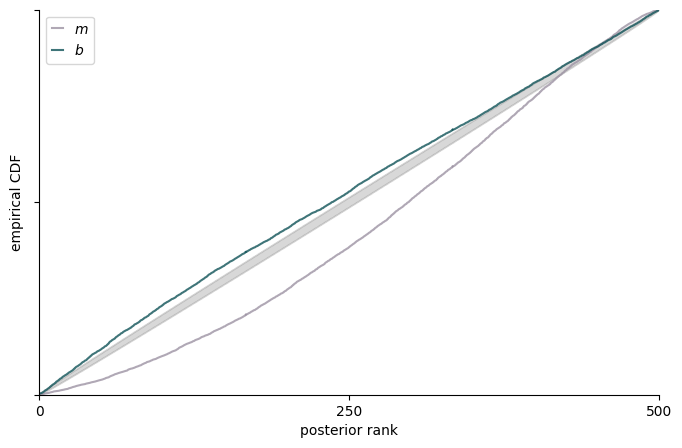

In [4]:
plot = CDFRanks(model, data, save=False, show=True)()

Sampling from the posterior for each observation: 10000observation [01:44, 96.00observation/s]


<Figure size 640x480 with 0 Axes>

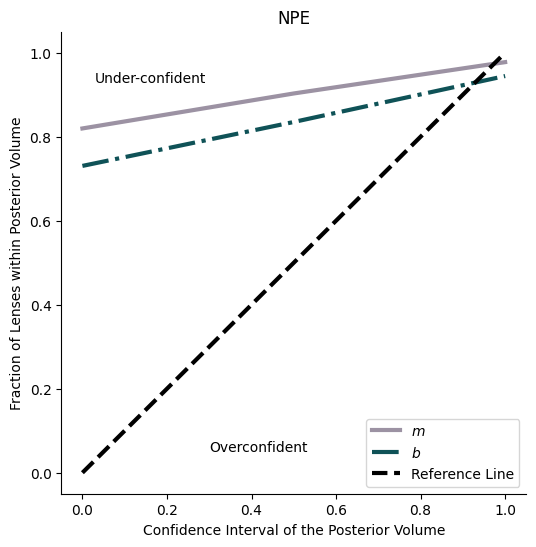

In [9]:
plot = CoverageFraction(model, data, show=True, save=False)()

/Users/maggiev-local/repo/DeepDiagnostics/src/plots/ranks.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  thetas = tensor(self.data.get_theta_true())
/Users/maggiev-local/repo/DeepDiagnostics/src/plots/ranks.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context = tensor(self.data.true_context())
Running 10000 sbc samples.: 100%|██████████| 10000/10000 [01:39<00:00, 100.20it/s]


<Figure size 640x480 with 0 Axes>

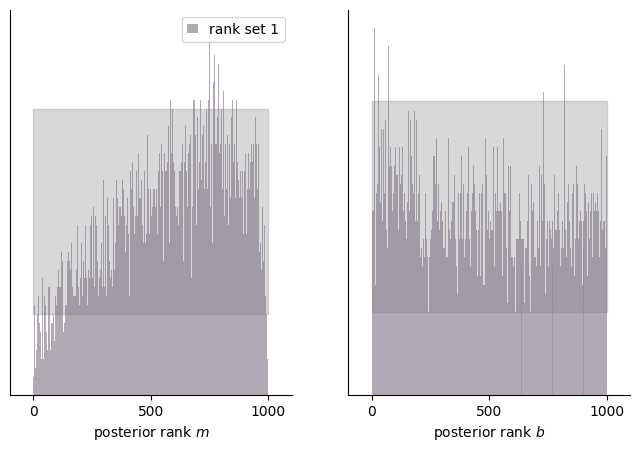

In [5]:
Ranks(model, data, show=True, save=False)()

100%|██████████| 100/100 [00:00<00:00, 759.05it/s]


<Figure size 640x480 with 0 Axes>

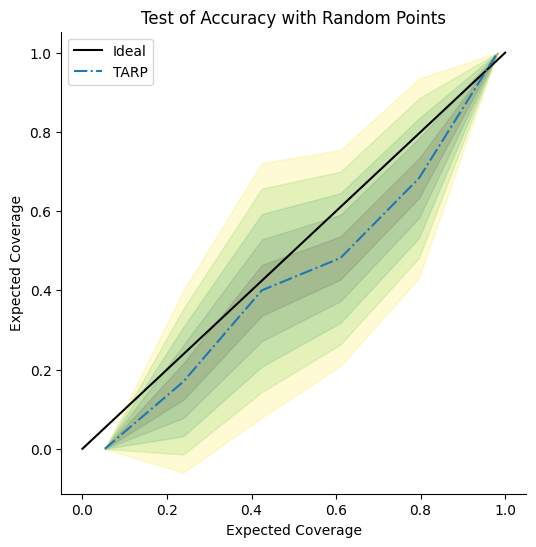

In [8]:
TARP(model, data, save=False, show=True)(
    coverage_sigma=5, bootstrap_calculation=True
)

<Figure size 640x480 with 0 Axes>

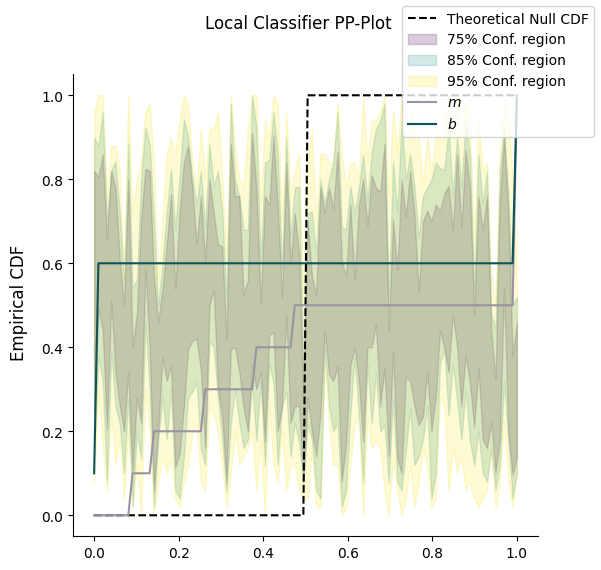

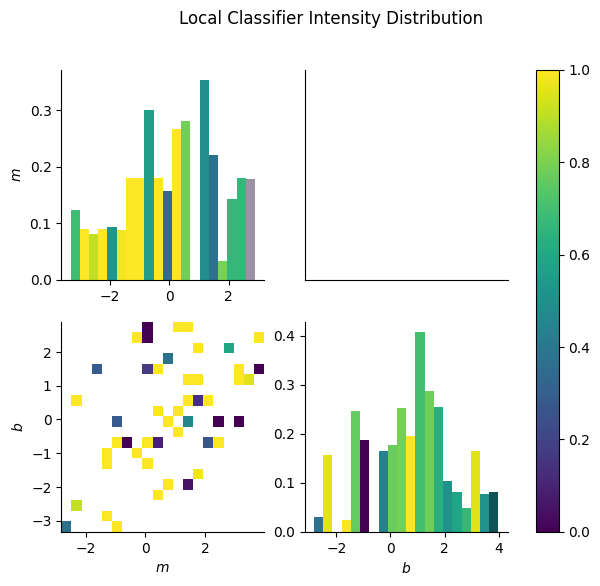

In [8]:
LocalTwoSampleTest(model, data, save=False, show=True)()

## Replicating with command line interface

To do the same thing with the CLI, just supply a config file with the metrics listed

In [2]:
my_config = {
    "model": {"model_path": "../resources/savedmodels/sbi/sbi_linear_from_data.pkl"}, 
    "data": {
        "data_path": "../resources/saveddata/data_validation.h5", 
        "simulator": "MySimulator"}, 
    "metrics_common": {
        "use_progress_bar": True,
        "samples_per_inference": 1000,
        "percentiles": [75, 85, 95],
        "number_simulations": 50}, 
    "metrics": {},
    "plots":{
        "LC2ST":{}, 
        "TARP":{"coverage_sigma":5, "bootstrap_calculation":True}, 
        "Ranks":{}, 
        "CoverageFraction":{}, 
        "CDFRanks":{}
    }
}
with open("./my_full_config.yaml", "w") as f: 
    yaml.safe_dump(my_config, f)

In [3]:
! diagnose --config ./my_full_config.yaml

/Users/maggiev-local/repo/DeepDiagnostics/src/plots/cdf_ranks.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  thetas = tensor(self.data.get_theta_true())
/Users/maggiev-local/repo/DeepDiagnostics/src/plots/cdf_ranks.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context = tensor(self.data.true_context())
Running 10000 sbc samples.: 100%|█████████| 10000/10000 [01:40<00:00, 99.17it/s]
Sampling from the posterior for each observation: 10000 observation [01:44, 95.86 observation/s]
/Users/maggiev-local/Library/Caches/pypoetry/virtualenvs/deepdiagnostics-081AeCAa-py3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochasti

In [4]:
import os 
os.listdir("./DeepDiagnosticsResources/results")

['coverage_fraction.png',
 'local_c2st_corner_plot.png',
 'local_c2st_pp_plot.png',
 'cdf_ranks.png',
 'tarp.png',
 'diagnostic_metrics.json',
 'ranks.png']